# Overview
The goal of this script is to create engine evaluations for the moves of the player in question grouped by game stage.

For this, I will use the "stockfish" package. https://pypi.org/project/stockfish/

Furthermore, I will divide each game into the sections opening, middle game and endgame.

## Imports and Data load

In [1]:
%pip install stockfish
%pip install pandas
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from stockfish import Stockfish


In [14]:
df = pd.read_csv("../data/rapid_games(LAN).csv")
df["LAN"] = df["LAN"].str.split()

### Setting up Stockfish
Setting parameters can be found here: https://github.com/official-stockfish/Stockfish/wiki/UCI-&-Commands

In [9]:
stockfish = Stockfish("C:/Users/phili/stockfish-windows-x86-64-avx2/stockfish/stockfish-windows-x86-64-avx2.exe")
stockfish.get_parameters()
stockfish.update_engine_parameters({"Hash": 2048,"Threads": 8})

## Move evaluation

In [17]:
def evaluate_move():
    """
    return: return a move's evaluation compared to the previous position (in centipawns).
    """
    mate_eval = 1400
    eval = stockfish.get_evaluation()

    if eval["type"] == "cp":
        return eval['value']
    else:
        if eval["value"] > 0:
            return mate_eval
        elif eval["value"] < 0:
            return mate_eval * -1
        else:
            return "checkmate"

In [20]:
move_list = df.loc[0,"LAN"][:-1]
evals = []
stockfish.set_depth(16)
stockfish.set_position()
for move in move_list:
    stockfish.make_moves_from_current_position([move])
    evals.append(evaluate_move())

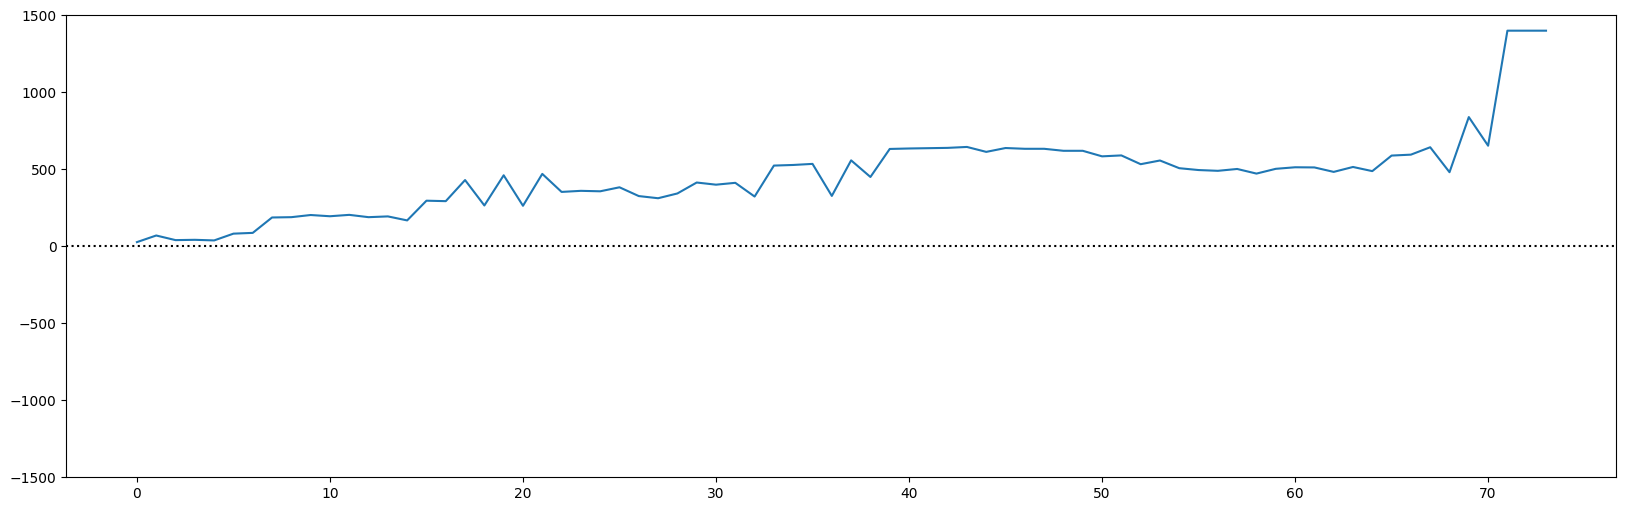

In [21]:
plt.figure(figsize=(20,6))
plt.plot(evals)
plt.ylim(-1500,1500)
plt.axhline(0, color="black", linestyle="dotted")

In [22]:
# Link to sample game:
df.loc[0,"id"]

'https://lichess.org/gEV7P53H'

### Depth of Search: Speed-Accuracy Tradeoff
- generally it is desirable to have a deeper stockfish evaluation, however, the time cost increases exponentially.

In [96]:
depths = [16, 18, 20, 22, 24, 26, 28]
times = []
evals_per_depth = []
import time

for depth in depths:
    stockfish.set_depth(depth)

    start = time.time()
    stockfish.set_position()
    evals = [stockfish.get_evaluation()["value"]]
    for move in move_list:
        stockfish.make_moves_from_current_position([move])
        evals.append(evaluate_move(move))
    evals_per_depth.append(evals)
    times.append(time.time() - start)


Text(0.5, 1.0, 'Evaluation Time Cost by Depth (56-move game)')

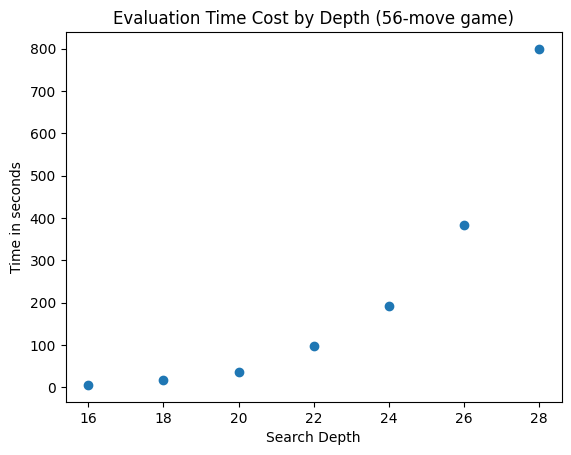

In [104]:
plt.scatter(depths, times)
plt.ylabel("Time in seconds")
plt.xlabel("Search Depth")
plt.title(f"Evaluation Time Cost by Depth ({len(move_list)}-move game)")

In [116]:
print(f"For {len(df.username.unique())} users:")
print(df.username.value_counts())
print(f"Total of {df.shape[0]} games")

For 15 users:
username
elgalgo72          902
Thinkersaurish     797
ChessCheens        523
AnishPanda2016     486
JeanEric           381
dyllos             381
Adrian_Glez        345
te989              326
JeremyMNunez       322
edahhani           239
Sarmiflex          208
Elcachoras12       202
SamuelTorrres      155
Melag              147
thenextbesthang    125
Name: count, dtype: int64
Total of 5539 games


- I read online that a depth of 20+ is recommended for reliable evaluations
- For this small sample of 5539 games the time cost would be approximately:

In [139]:
time_cost = pd.DataFrame(depths, columns=["depth"])
time_cost["computational cost in hours"] = list(map(lambda x: x* 5539/3600, times))
time_cost["computational cost in hours"] = time_cost["computational cost in hours"].astype(int)
time_cost

,depth,computational cost in hours
0,16,8
1,18,24
2,20,54
3,22,149
4,24,296
5,26,588
6,28,1229


## Ideas to deal with this problem:
- exclude users who have many games
- randomly sample a portion of the total games for each user
- restrict time range
- create a look-up table for move sequences that were already computed to avoid recomputations
- compute multiple games in parallel

## Material
  Pieces are valued with the following points:
  - queen: 9 points.
  - rook: 5 points.
  - bishop/Knight: 3 points.
  - pawn: 1 point.

In [13]:
def get_piece_value(piece):
    piece_values = {
        # White:
        "K": 0,
        "Q": 9,
        "R": 5,
        "B": 3,
        "N": 3,
        "P": 1,
        # Black:
        "k": 0,
        "q": -9,
        "r": -5,
        "b": -3,
        "n": -3,
        "p": -1,
    }
    try: 
        return piece_values[piece.value]
    except AttributeError:  # case when no piece is on a given square
        return 0

## Game stage
- Opening is defined as: Moves 1-10
- Middlegame is defined as: Moves after middle game and before endgame
- Endgame is defined as: from the move at which both sides have less than *13 points* in material. This definition is adopted from Speelman (Speelman, Jonathan (1981), Endgame Preparation, Batsford, ISBN 0-7134-4000-7 - https://en.wikipedia.org/wiki/Chess_endgame#The_start_of_the_endgame)

In [14]:
def get_material_counts():
    files = string.ascii_lowercase[0:8] # get a-h
    white, black = 0, 0
    
    for file in files:
        for rank in range(1,9):
            piece = stockfish.get_what_is_on_square(file+str(rank)) # returns None if there is no piece
            if not piece:
                pass
            piece_value = get_piece_value(piece)
            if piece_value > 0:
                white += piece_value
            else:
                black += abs(piece_value)
    return (white, black)


## Putting it all together

Now that we have all the elements needed to analyze an entire game and defined how to evaluate the game stage, we can write a function to analyze an entire game given the move-sequence in LAN notation.

In [15]:
def get_evaluations(moves: list): #, white: bool):
    stage, evals = [],[]
    # set up board position:
    stockfish.set_position()
    # loop through the game
    reached_endgame = False # once you enter the endgame, you can never go back
    for i, move in enumerate(moves):
        stockfish.make_moves_from_current_position([move])
        evals.append(evaluate_move(move))
        if i < 20:
            stage.append("opening")
        elif not reached_endgame and max(get_material_counts())>13:
            stage.append("middle")
        else:
            stage.append("ending")

    return (evals, stage)

Example of a small sample:

In [21]:
df["LAN"] = df["LAN"].str.split()
df["evaluation"] = df.apply(lambda x: get_evaluations(x["LAN"]), axis=1)

In [29]:
df = df.reset_index(drop=True)

In [ ]:
evals = pd.DataFrame(df["evaluation"].to_list(), columns=["evaluation", "stage"])
rapid_games = df.drop(labels="evaluation", axis=1)
rapid_games = pd.concat([rapid_games, evals], axis=1)
rapid_games

### From Centipawns to Accuracies

The formulas provided by lichess (https://lichess.org/page/accuracy) are:

For the win percentage $w_t$ given the position evaluation in centipawns:
$$
w_t(centipawns) = 50 + 50 *(\frac{2}{1 + e^{-0.00368208 * centipawns}} - 1)
$$

and for the accuracy percentage given the win percentage before a move $w_{t-1}$ and the win percentage after a move $w_{t}$:
$$
Accuracy(w_{t-1}, w_{t}) = 103.1668 * e^{-0.04354 * (w_{t-1} - w_{t})} - 3.1669
$$

In [62]:
def get_win_percent(evaluations):
    return [50 + 50 * (2 / (1 + np.e**(-0.00368208 * cp)) - 1) for cp in evaluations]

In [66]:
def get_accuracies(win_percentages):
    return [103.1668 * np.e**(-0.04354 * (win_percentages[i-1] - win_percentages[i])) - 3.1669 for i in range(1, len(win_percentages))]

In [63]:
sample_game = rapid_games.loc[0,"evaluation"][:-1]
get_win_percent(sample_game)

[52.66697440308632,
 56.950652664707015,
 53.76698043044984,
 53.58387144707508,
 53.85849714102531,
 59.10258971916128,
 59.812643568627436,
 66.40030811678618,
 66.64630487993782,
 65.90564612649169,
 67.05428791057813,
 67.86254827184692,
 66.31811026712697,
 67.13557948833915,
 64.23206501894636,
 74.13649232497093,
 73.92412438359773,
 83.58240437072985,
 76.2642034262642,
 84.42339860303731,
 72.40628269004114,
 85.6864845578129,
 78.14266583095537,
 78.57969855524269,
 78.82656217191823,
 79.01034009176922,
 76.66179647685237,
 77.24945149239734,
 76.66179647685237,
 81.79155706687055,
 81.34874545019301,
 81.06779899506586,
 76.66179647685237,
 87.60108570678773,
 87.03024236418142,
 87.64102358709695,
 77.76298320139679,
 88.34118629871755,
 84.80684627039938,
 91.07959528114046,
 91.13924591731603,
 91.31604245116785,
 91.31604245116785,
 91.2867996687703,
 90.71403124659402,
 91.16893600511021,
 90.95920634631364,
 90.89846472089855,
 90.68296806302777,
 90.71403124659402,
 

In [46]:
rapid_games.to_csv("../data/rapid_games_evals.csv")

### To Do
- change the metric:
    
    measure *accuracy* instead of the *mean centipawn loss* because losing centipawns is much more impactful if the position is in equillibrium than if one side has a winning position which is not taken into account by *mean centipawn loss*. https://lichess.org/page/accuracy , https://zwischenzug.substack.com/p/centipawns-suck
- decide on evaluation behaviour if the evaluation is given in checkmate instead of centipawns
    -> went for +/- 1400 centipawns
- measure number of blunders in a game - find a metric to decide on which moves qualify as a blunder
- ~~rewrite function from evaluate game() to evaluate move()~~
- ~~let get_average_centipawn_loss() loop through a game once instead of twice (stockfish.set_position and stockfish.make_move_from_position(move))~~